## Doing it all with Statsmodels

PACF - Find AR order 
ACF - Find MA order 
Find AR order for coefficients using PACF - use graph  
Look at over or under boundary  

Find MA coefficients using ACF - PACF not such a good source here  

Use augmented dickey-fuller to decide how many diffs to do  


In [1]:
import pandas as pd
import math
import numpy as np

df = pd.read_csv('./data/CO2_monthly.csv')
# series = jobs_df['Vacancies']

def rmse(predicted, actual):
    diffs = predicted - actual
    return math.sqrt(np.mean(diffs ** 2))

In [2]:
CO2_df = df['Interpolated'].rename('Observed').to_frame()

We are going to deploy an ARIMA model.   
Start by computing the PACF and ACF to
inform our choice of orders for the AR and MA components respectively.  

First the ACF

### ACF 
Next do the ACF function  
"To what extent does each value seem te be affected by the K value before it"  



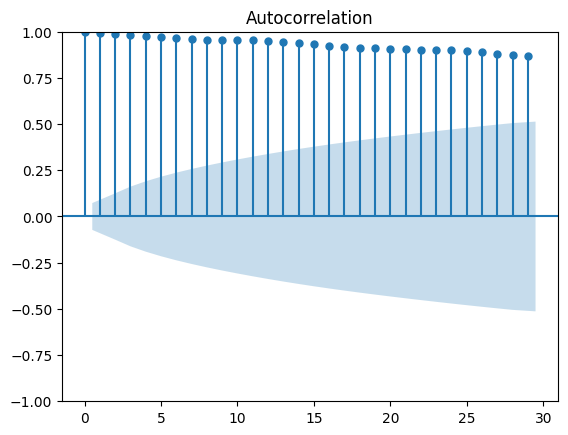

In [3]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(CO2_df['Observed'])
pyplot.show()

Find don't get much useful information as its just always high  

Choose a relatively high MA order then - 10



### PACF

Partial ACF is much more complicated  

If know the one 10 back affects you now, you know it affects the one 9 back, 8 back etc.  
We want to mod all of that out - this is PACF  
Trying to find the effect of the one 10 back, without the intervening effects

c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


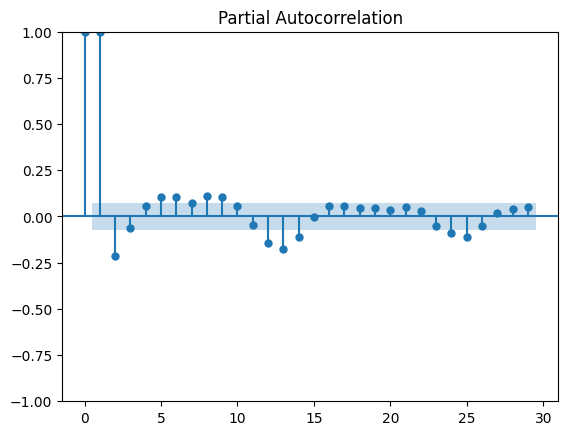

In [4]:
plot_pacf(CO2_df['Observed'])
pyplot.show()

one, two definitely useful, three,I think is just about useful so does it look like 11, 12, 13.I guess that's because of the seasonality,but I'm going to ignore that and just use the one, two, three,I'm going to make this an AR3

Need to decide about the I part now, use ADF

In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(CO2_df['Observed'])
print('p-value: %f' % result[1])

p-value: 1.000000


p-value 1 so definitely not stationary - try the shift

In [6]:
X = (CO2_df['Observed'] - CO2_df['Observed'].shift()).dropna()
result_shift = adfuller(X)
print('p-value: %f' % result_shift[1])

p-value: 0.000006


p-value < 0.05 so now stationary

Because ACF seemed high, making MA bit high

**Trend Parameter** telling you whether - default is trend equals C,which is a constant   
trend equals N means there's no trend.  
What that means is,when we look at the AR it's a matter of whether we're using what's biased or unbiased, the interpretation
if you allow yourself to have to geta best line fit with going any place, there's a bias.You can get something like the Y intercept plus MX or something.This is in two dimensions, and that's called biased.The biased is that initial value where it meets the Y-axis.If on the other hand, you assume that you're lookingfor a line that goes through the origin, where it hits the Y-axis to zero,that's called unbiased and that's what we've done all along.That's why I've made the trend equals N.You actually get a better fit if you allow trend to be C,which is what would happen if I left this off



In [7]:
import statsmodels.api as sm

# AR(3) I(1) MA(10)
model = sm.tsa.arima.ARIMA(CO2_df['Observed'], order=(3,1,10), trend='n')
res = model.fit()
print(res.summary())


                               SARIMAX Results                                
Dep. Variable:               Observed   No. Observations:                  727
Model:                ARIMA(3, 1, 10)   Log Likelihood                -493.417
Date:                Sat, 27 Aug 2022   AIC                           1014.834
Time:                        12:28:02   BIC                           1079.060
Sample:                             0   HQIC                          1039.619
                                - 727                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9166      0.215      4.272      0.000       0.496       1.337
ar.L2          0.4089      0.371      1.102      0.270      -0.318       1.136
ar.L3         -0.8121      0.214     -3.793      0.0

c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Make a prediction column using the model

In [8]:
CO2_df['Prediction'] = res.predict()
CO2_df.head()

,Observed,Prediction
0,315.71,0.000000
1,317.45,315.710146
2,317.50,318.490910
3,317.10,317.047157
4,315.86,316.376554


<AxesSubplot:>

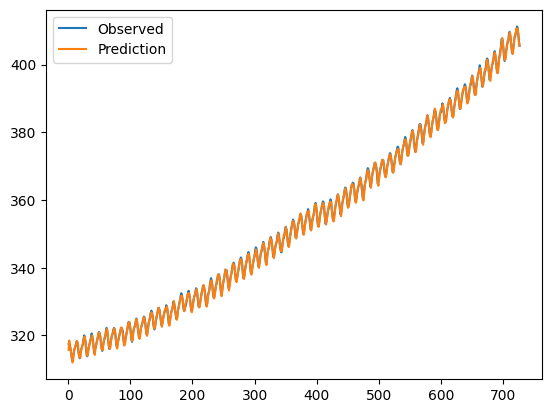

In [9]:
# Get rid of first 0 row
CO2_df = CO2_df[1:]
CO2_df.plot()

In [10]:
# calculate RMSE

print(rmse(CO2_df['Observed'], CO2_df['Prediction']))

0.480701233047204
